# **TP Traitement automatique des langues**

## **Introduction**

Le Traitement Automatique des Langues (**TAL**), *Natural Language Processing* (**NLP**)  en anglais, est un domaine multidisciplinaire impliquant la linguistique, l’informatique et l’intelligence artificielle qui vise à créer des outils de traitement de textes pour diverses applications.

Les outils de TAL prennent généralement la forme d'algorithmes implémentés sur des ordinateurs. Ces derniers ne pouvant traiter que des opérations entre des nombres, l'une des problématiques majeures du domaine est la suivante :

**Comment transformer des données textuelles en données numériques pour pouvoir les traiter automatiquement avec des ordinateurs ?**

L'une des solutions à cette problématique réside dans une notion au coeur du TAL moderne : le **plongement lexical**, *word embedding* en anglais.

L'embedding d'un mot est une manière de le représenter sous la forme d'un vecteur de nombres réels. La propriété principale de cette représentation vectorielle est que deux mots qui apparaissent dans des contextes similaires doivent être représentés par des embeddings proches. Par exemple :

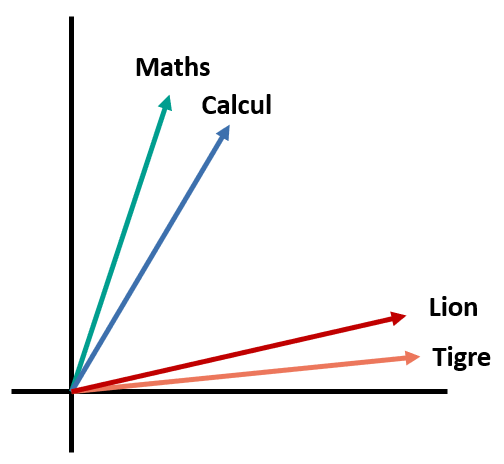


Une fois un texte transformé en une suite d'embeddings, il est possible de réaliser une multitude de tâches : classification de texte, anaylse de sentiment, génération de texte, traduction... La majorité des outils modernes de TAL (dont ChatGPT, Mistral...) utilise cette représentation des mots sous forme d'embedding.

---

**L'objectif de ce TP est d'explorer la notion d'embedding et d'appliquer les concepts de base pour implémenter un moteur de recherche sémantique pour vos documents.**

---



## **0. Installations, imports et définition de fonctions**

### Installations

In [ ]:
# Install dependencies
%pip install --no-deps sentence-transformers
%pip install langchain_text_splitters
%pip install langchain_community
%pip install pdfminer.six

### Imports

In [9]:
import numpy as np
import pandas as pd
from typing import List

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

import plotly.express as px
from plotly.graph_objs._figure import Figure

from sentence_transformers import SentenceTransformer

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PDFMinerLoader

### Définition des fonctions

In [48]:
def plot_embeddings(sentences: List[str], embeddings: np.ndarray) -> Figure:
    """
    Function to plot word embeddings in a 2D reduced space.
    Uses PCA algorithm to reduce dimension.
    """
    # Reduce embeddings dimension to plot it on a 2D graph
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Get x and y coordinates
    x_coords = [point[0] for point in reduced_embeddings]
    y_coords = [point[1] for point in reduced_embeddings]

    # Plot embeddings using Plotly scatterplot
    df = pd.DataFrame({'x': x_coords, 'y': y_coords, 'text': sentences})
    fig = px.scatter(df, x="x", y="y", hover_name='text', hover_data={'x': False, 'y': False})
    fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='black')
    fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='black')

    return fig

In [4]:
def get_text_chunks(file_path: str, chunk_size: int =200, chunk_overlap: int = 20) -> List[str]:
    """
    Function to chunk a pdf file into smaller text extracts.
    """
    # Parse PDF
    loader = PDFMinerLoader(file_path)
    full_text = loader.load()[0].page_content

    # Chunk it
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        )
    splits = text_splitter.create_documents([full_text])
    chunks = [split.page_content for split in splits]
    return chunks

## **1. Découverte de HuggingFace 🤗**

HuggingFace 🤗 est une plate-forme permettant le partage de modèles, de données et de code dans le domaine du TAL, et plus marginalement dans d'autres domaines de l'apprentissage automatique (vision par ordinateur, apprentissage par renforcement). Le site permet à n'importe qui (du simple utilisateur aux grandes entreprises comme Meta ou Mistral) de partager son travail pour qu'il soit utilisable par la communauté.

Aujourd'hui, quand on commence un projet impliquant du TAL, il est rare de devoir implémenter un modèle depuis zéro. Une bonne pratique est d'explorer HuggingFace pour vérifier s'il n'existe pas des modèles en lien avec la problématique que l'on essaie de résoudre.

**Pour créer notre moteur de recherche sémantique, l'objectif est de pouvoir comparer la requête d'un utilisateur avec des documents pour trouver les plus proches sémantiquement**. Comme nous voulons comparer deux textes et non uniquement deux mots, nous allons avoir besoin d'un modèle qui permette de calculer un embedding unique pour un texte de plusieurs mots. Ces modèles s'appellent des **modèles de similarité de phrase**, *sentence similarity* en anglais.

### Tâche 1

---
**Trouvez un modèle de similarité de phrase français sur HuggingFace.**

* Rendez-vous sur le site HuggingFace : [https://huggingface.co/](https://huggingface.co/)
* Explorez les modèles disponibles dans la page *models*
* Trouvez un modèle qui correspond aux caractéristiques suivantes :
    * entraîné sur une tâche de similarité de phrase (*sentence similarity*)
    * utilisable sur des textes en langue française

---

#### Solution

Les modèles peuvent être trouvés à l'adresse suivante :

https://huggingface.co/models?pipeline_tag=sentence-similarity&language=fr&sort=trending

## **2. Chargement et exploration du modèle**

Dans la suite, nous utilisons le modèle `sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2`.

Libre à vous d'utiliser le modèle de votre choix !

Pour charger le modèle, on utilise la librairie [SentenceTransformers](https://www.sbert.net/) qui facilite l'utilisation des modèles de similarité de phrase.

In [5]:
# Charge default model
model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
model = SentenceTransformer(model_name)

### Tokenizer

Les modèles de langages ne traitent pas une séquence de mots mais une séquence de tokens. Un token peut représenter un mot, une partie de mot, un caractère unique, un signe de ponctuation, un caractère spécial...

Cette représentation en token permet d'avoir une plus grande flexibilité dans la représentation des mots et de mieux traiter les mots que le modèle n'a jamais vu pendant son entraînement.

In [ ]:
sentence = "RTE est le gestionnaire du réseau de transport d'électricité."

# Tokenize the sentence
tokenized = model.tokenizer.tokenize(sentence)

# Print each token
print(" | ".join(tokenized))

### Modèle

Calculer l'embedding d'une phrase avec notre modèle se fait simplement :

In [ ]:
sentence = "RTE est le gestionnaire du réseau de transport d'électricité."

# Embed the sentence using the model
embedding = model.encode(sentence)

# Print info about the embedding
print(f"Dimension d'embedding : {len(embedding)}")
print(f"Embedding est de type : {type(embedding)}")
print(f"Embedding : {embedding[0:5]}...")

### Tâche 2

---

**Calculez le score de similarité entre 2 phrases.**

* Définissez deux phrases
* Calculez leur embedding en utilisant le modèle
* Calculez le score de similarité entre les deux embeddings

La fonction de distance utilisée sera la similarité cosinus. Vous pourrez utiliser la fonction [`cosine_similarity`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) du package scikit-learn :

```
vector_1 = np.array([1,2,3])
vector_2 = np.array([4,5,6])

similarity_score = cosine_similarity([vector_1], [vector_2])
```

---





In [ ]:
# Votre code


#### Aide

```
# Define 2 sentences
sentences = [
    "...",
    "...",
]

# Compute embeddings using model
embeddings = ...

# Compute similarity using cosine_similarity
similarity_score = ...

# Print result
print(f"Similarité entre les deux phrases : {similarity_score.squeeze():.2f}")
```



#### Solution

In [7]:
# Define 2 sentences
sentences = [
    "RTE est le gestionnaire du réseau de transport d'électricité.",
    "L'équilibre entre l'offre et la demande d'électricité est une mission du GRT."
]

# Compute embeddings using model
embeddings = model.encode(sentences)

# Compute similarity using cosine_similarity
similarity_score = cosine_similarity([embeddings[0]], [embeddings[1]])

# Print result
print(f"Similarité entre les deux phrases : {similarity_score.squeeze():.2f}")

Similarité entre les deux phrases : 0.53


### Représentation graphique des embeddings

Le modèle de similarité de phrase génère des embeddings proches dans l'espace vectoriel pour les phrases sémantiquement proches.

On peut le vérifier en affichant les embeddings dans un espace de dimension 2D.

In [49]:
sentences = [
    "RTE est le gestionnaire du réseau de transport d'électricité.",
    "L'équilibre entre l'offre et la demande d'électricité est une mission du GRT.",
    "Un embedding est une représentation vectorielle d'un mot.",
    "Les modèles Transformers utilisent les embeddings pour réaliser des calculs avec des mots.",
	"La recette des crêpes est très simple !",
]

# Embed sentences
embeddings = model.encode(sentences)

# Plot embeddings in a 2D graph
plot_embeddings(sentences, embeddings)

## **3. Application : recherche sémantique dans un document**

Nous avons un modèle qui nous permet de calculer mathématiquement la similarité sémantique entre deux phrases. Cet outil peut nous permettre d'implémenter un moteur de recherche sémantique pour des documents :

* les documents dans lesquels on souhaite chercher de l'information sont transformés en embeddings
* l'utilisateur entre une requête textuelle
* on calcule l'embedding de cette requête
* on calcule la similarité sémantique entre la requête et chaque document
* on retourne les documents les plus proches sémantiquement

Ce principe est à la base de beaucoup de moteurs de recherche modernes (type Google).

### Tâche 3

---

**Utilisez le modèle pour chercher des informations par similarité sémantique dans un fichier PDF.**

* Utilisez la fonction `get_text_chunks` pour parser le contenu textuel du fichier et le découper en extraits (*chunks*)
* Utilisez le modèle pour calculer les embeddings de chaque extrait
* Écrivez une question en calculez son embedding
* Calculez la similarité entre chaque extrait et votre question
* Affichez les extraits ayant les scores de similarité les plus élevés avec votre question

---

Pour réaliser le TP, le fichier utilisé par défaut est la synthèse du [Bilan électrique 2023](https://analysesetdonnees.rte-france.com/bilan-electrique-2023/synthese) publié par RTE.

Vous pouvez essayer avec votre propre document (au format `.pdf`) en le téléchargeant dans Colab.

In [ ]:
# Download an example pdf file
!wget https://assets.rte-france.com/prod/public/2024-02/Bilan-electrique-2023-synthese.pdf

In [ ]:
# Votre code


#### Aide



```
# Parse textual content in file and chunk it
file_path = "./Bilan-electrique-2023-synthese.pdf"
chunks = ...

print(f"Nombre d'extraits : {len(chunks)}")

# Explore chunks
print(chunks[0])

# Embed chunks
chunks_embeddings = ...
print(chunks_embeddings.shape)

# Write and embed query
query = "..."
query_embedding = ...

# Compute cosine similarity between query and chunks
similarity_score = ...

# Get top_n highest similarity indexes
top_n = 5
top_indexes = np.argsort(similarity_score)[-top_n:][::-1]

# Print retrieved chunks
for i, top_index in enumerate(top_indexes):
    print(f"Extrait numéro {i+1}")
    print(f"Score de similarité : {similarity_score[top_index]:.2f}")
    print("```")
    print(chunks[top_index])
    print("```")
    print("\n-----------------\n")
```



#### Solution

In [ ]:
# Parse textual content in file and chunk it
file_path = "./Bilan-electrique-2023-synthese.pdf" # change this line if you want to try on your doc
chunks = get_text_chunks(file_path, chunk_size=200, chunk_overlap=20)

print(f"Nombre d'extraits : {len(chunks)}")

In [ ]:
# Explore chunks
print(chunks[0])

In [ ]:
# Embed chunks
chunks_embeddings = model.encode(chunks, show_progress_bar=True)
print(chunks_embeddings.shape)

In [ ]:
# Write and embed query
query = "Comment a évolué la consommation électrique entre 2022 et 2023 ?"
query_embedding = model.encode(query)

# Compute cosine similarity between query and chunks
similarity_score = cosine_similarity([query_embedding], chunks_embeddings).squeeze()

# Get top_n highest similarity indexes
top_n = 5
top_indexes = np.argsort(similarity_score)[-top_n:][::-1]

# Print retrieved chunks
for i, top_index in enumerate(top_indexes):
    print(f"Extrait numéro {i+1}")
    print(f"Score de similarité : {similarity_score[top_index]:.2f}")
    print("```")
    print(chunks[top_index])
    print("```")
    print("\n-----------------\n")